# Importación de librerías

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

from src.image_processing_functions import *
from src.utility_functions import read_images_from_directory

# Detección en cada imagen
Obtener una detección del logo en cada imagen sin falsos positivos

In [2]:
template_path = 'template/pattern.png'
images_directory = 'images'

A continuación, se leen todas las imágenes mediante la función [read_images_from_directory](src/utility_functions.py) y se obtiene una detección de cada imagen mediante la función [detect_single_logo_in_image](src/image_processing_functions.py). Esta función recibe una imagen, un template y muestra la detección del template en la imagen con un nivel de confianza determinado.

Median value: 74.0, lower: 10, upper: 250
Template height ratio: 0.29264214046822745
Template width ratio: 0.5006257822277848
Best scale: 0.2
Best matching score: 0.2931707799434662


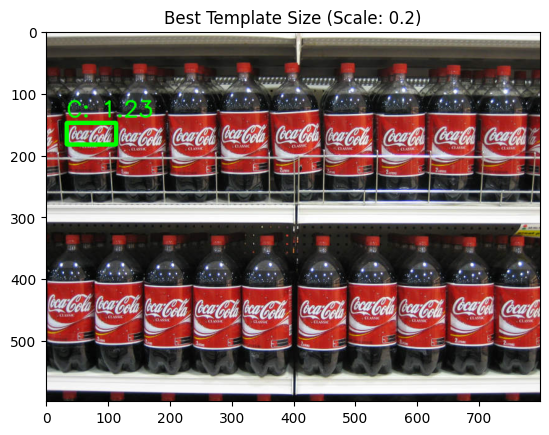

Median value: 83.0, lower: 300, upper: 450
Template height ratio: 0.40792540792540793
Template width ratio: 0.5594405594405595
Best scale: 0.5
Best matching score: 0.2295190691947937


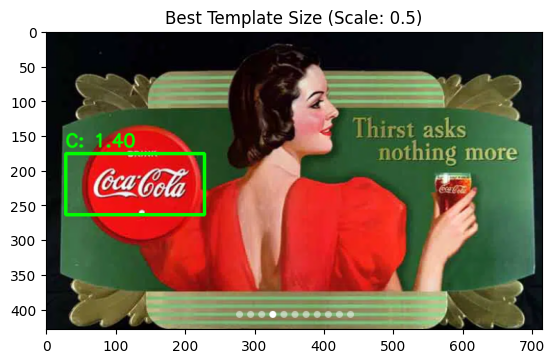

Median value: 94.0, lower: 300, upper: 450
Template height ratio: 0.35
Template width ratio: 1.932367149758454
Best scale: 0.5
Best matching score: 0.16821308434009552


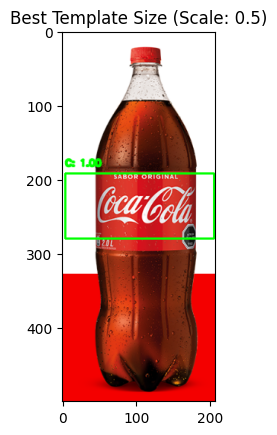

High contrast image
Median value: 224.0, lower: 100, upper: 540
Template height ratio: 0.35496957403651114
Template width ratio: 0.5594405594405595
Best scale: 1.3421052631578947
Best matching score: 0.14974960684776306


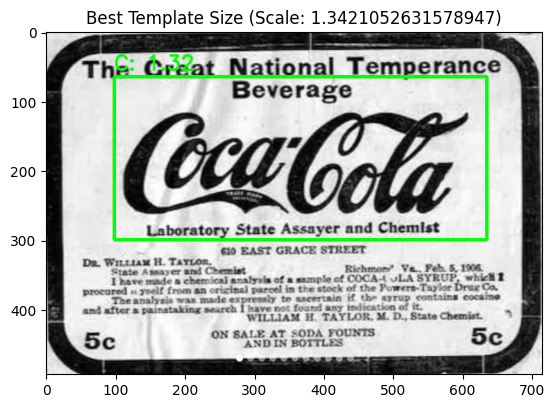

Median value: 41.0, lower: 10, upper: 250
Template height ratio: 0.3888888888888889
Template width ratio: 0.5822416302765647
Best scale: 0.763157894736842
Best matching score: 0.21383625268936157


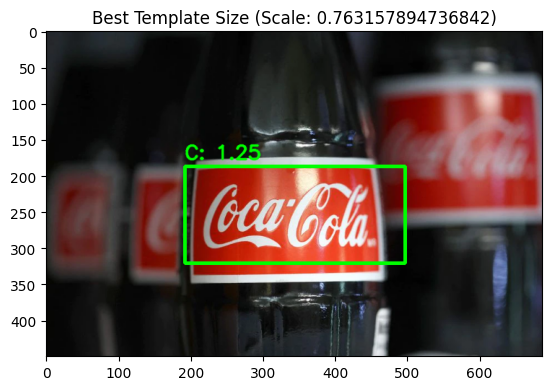

Median value: 80.0, lower: 300, upper: 450
Template height ratio: 0.4820936639118457
Template width ratio: 1.7167381974248928
Best scale: 0.5526315789473684
Best matching score: 0.18192866444587708


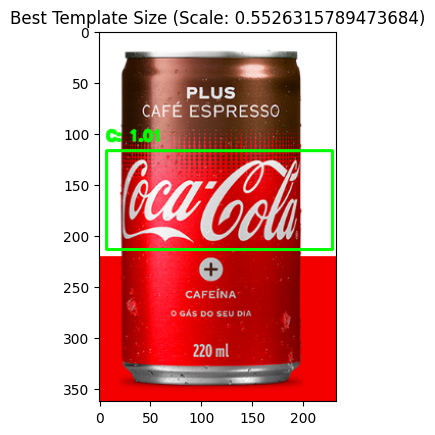

Median value: 92.0, lower: 300, upper: 450
Template height ratio: 0.1259899208063355
Template width ratio: 0.28797696184305255
Best scale: 3.1578947368421053
Best matching score: 0.08287764340639114


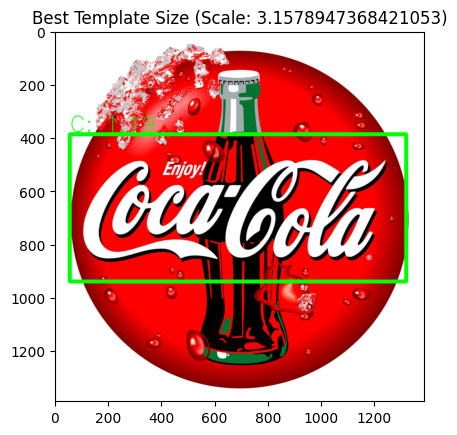

In [4]:
# Read images from the directory
images = read_images_from_directory(images_directory)

for img_path in images:
    # Detect the logo in the current image
    detect_single_logo_in_image(img_path, template_path)

El nivel de confianza se calculó mediante la función [calculate_confidence_level](src/utility_functions.py) que recibe una lista de scores, junto con el mejor score. El nivel de confianza se calcula como la relación entre el mejor score y el percentil 90, proporcionando una medida de que tan superior es el mejor score en comparación con la mayoría de los scores obtenidos.

Siendo el niveles de confianza cercanos o iguales a 1, se considera que la detección es correcta. Mayores a 1, se considera que la detección es muy buena. Menores a 1, se considera que la detección es mala.

# Múltiples detecciones en una imagen

Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1

Para este caso se planteará el procedimiento de la siguiente celda. Se carga la imagen que se trabajará y la plantilla, ambas convertidas a escala de grises, y se aplica desenfoque gaussiano a la imagen principal. La plantilla se redimensiona según una proporción definida respecto al tamaño de la imagen principal. Luego, se aplica el detector de bordes Canny a ambas imágenes y se realiza el *matching* de la plantilla sobre la imagen principal. Se identifican las ubicaciones de coincidencia, se eliminan las redundantes mediante *Non Maximum Suppression* y se dibujan rectángulos alrededor de las coincidencias en la imagen original, mostrando el resultado final.

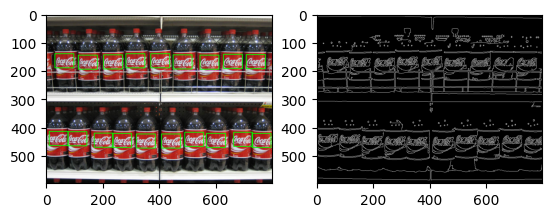

In [2]:
# Load the image and convert to grayscale
img_rgb = cv.imread('images/coca_multi.png')
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

# Load the template and get its dimensions
template = cv.imread('template/pattern.png', 0)

# Apply Gaussian blur to the image
img_gray_blurred = cv.GaussianBlur(img_gray, (5, 5), 0)

# Get dimensions of the image and template
img_height, img_width = img_gray_blurred.shape

# Define the desired size ratio for the template
size_ratio = 0.085

# Calculate new dimensions for the template based on the size ratio
new_template_width = int(img_width * size_ratio)
new_template_height = int(img_height * size_ratio)

# Resize the template
template = cv.resize(template, (new_template_width, new_template_height))

# Get the dimensions of the resized template
template_width, template_height = template.shape[::-1]

# Apply Canny edge detection to the image and template
template_edges = cv.Canny(template, 50, 300, L2gradient=True)
img_gray_edges = cv.Canny(img_gray_blurred, 10, 250, apertureSize=3, L2gradient=True)

# Perform template matching
res = cv.matchTemplate(img_gray_edges, template_edges, cv.TM_CCOEFF_NORMED)

# Set the threshold for the template matching result
threshold = 0.16

# Find the locations where the template matches the image
loc = np.where(res >= threshold)

# Prepare lists of bounding boxes and scores
boxes = []
scores = []

for pt in zip(*loc[::-1]):
    boxes.append([pt[0], pt[1], template_width, template_height])
    scores.append(res[pt[1], pt[0]])

boxes = np.array(boxes)
scores = np.array(scores)

# Apply non-maximum suppression
iou_threshold = 0.3
keep = non_max_suppression(boxes, scores, iou_threshold)

# Draw rectangles around the kept bounding boxes
for i in keep:
    box = boxes[i]
    cv.rectangle(img_rgb, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 255, 0), 2)

# Display the result
plt.subplot(121)
plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))

plt.subplot(122)
plt.imshow(img_gray_edges, cmap='gray')
plt.show()

# Generalización del algoritmo de detección

Generalizar el algoritmo del item 2 para todas las imágenes.

In [6]:
def adjust_template_size(template: np.ndarray, img_width: int, img_height: int) -> np.ndarray:
    # Get dimensions of the template
    template_height, template_width = template.shape
    print(f"Original template dimensions: {template_width}x{template_height}")
    print(f"Image dimensions: {img_width}x{img_height}")
    
    # Calculate the size ratio of the template to the image
    width_ratio = template_width / img_width
    height_ratio = template_height / img_height
    print(f"Original width ratio: {width_ratio}, Original height ratio: {height_ratio}")
    
    if height_ratio < 0.25:
        template = cv.resize(template, (template_width, int(template_height * 0.5)))

    # Adjust the template size if it is significantly smaller than the image
    if width_ratio < 0.5 and height_ratio < 0.5:
        template = cv.pyrUp(template)  # Upscale the template
        template_width, template_height = template.shape[::-1]
        width_ratio = template_width / img_width
        height_ratio = template_height / img_height
        print(f"Upscaled template dimensions: {template_width}x{template_height}")
        print(f"New width ratio: {width_ratio}, New height ratio: {height_ratio}")
    else:
        # Otherwise, downscale the template
        template = cv.pyrDown(template)
        template_width, template_height = template.shape[::-1]
        width_ratio = template_width / img_width
        height_ratio = template_height / img_height
        print(f"Downscaled template dimensions: {template_width}x{template_height}")
        print(f"New width ratio: {width_ratio}, New height ratio: {height_ratio}")
        
        # If the template is still too large, downscale it further
        if width_ratio > 1 or height_ratio > 1:
            template = cv.pyrDown(template)
            template_width, template_height = template.shape[::-1]
            print(f"Further downscaled template dimensions: {template_width}x{template_height}")
            width_ratio = template_width / img_width
            height_ratio = template_height / img_height
            print(f"Final width ratio: {width_ratio}, Final height ratio: {height_ratio}")

    return template

In [7]:
def auto_canny(image: np.ndarray, sigma: float = 0.33) -> np.ndarray:
    """
    Apply Canny edge detection using automatic thresholding.
    The thresholds are calculated based on the median of the pixel intensities.
    """
    median_value = np.median(image)
    lower = int(max(0, (1.0 - sigma) * median_value))
    upper = int(min(255, (1.0 + sigma) * median_value))
    
    if median_value > 200:
        lower = 100
        upper = 700
        
    if median_value > 50 and median_value < 100:
        lower = 10
        upper = 250
    
    edged = cv.Canny(image, lower, upper, appeL2gradient=True)
    return edged, median_value

In [8]:
def detect_image_with_template(
    img_gray: np.ndarray,
    template_gray: np.ndarray,
    method: str = 'cv.TM_CCORR_NORMED'
):
    # Get dimensions of the image and template
    img_height, img_width = img_gray.shape
    template_height, template_width = template_gray.shape
    
    # Apply edge detection
    template_edges = cv.Canny(template_gray, threshold1=50, threshold2=100, L2gradient=True)
    img_edges, median = auto_canny(img_gray) 
    # img_edges = cv.Canny(img_gray, 150, 700, L2gradient=True)
    
    if median > 200:
        print("High contrast image")
        kernel = np.ones((3, 3), np.uint8)

        img_edges = cv.dilate(img_gray_edges, kernel, iterations=2)
        
    
    # Adjust the size of the template based on the size ratio with the image
    template_edges = adjust_template_size(template_edges, img_width, img_height)
    
    # Template matching method
    method = eval(method)
    
    # Perform template matching
    res = cv.matchTemplate(img_edges, template_edges, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    
    # Find the location of the best match
    top_left = max_loc
    template_height, template_width = template_edges.shape
    bottom_right = (top_left[0] + template_width, top_left[1] + template_height)
    
    return res, (top_left, bottom_right), img_edges, template_edges

In [9]:
# Directory of images and template path
images_directory = 'images'
template_path = 'template/pattern.png'
method = 'cv.TM_CCORR_NORMED'

# Read images from the directory
images = read_images_from_directory(images_directory, True)

# Read the template in grayscale
template_gray = cv.imread(template_path, cv.IMREAD_GRAYSCALE)

for img_path in images:
    # Read the image in color and convert to RGB for visualization
    img = cv.imread(img_path, cv.IMREAD_COLOR)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # Apply Gaussian blur to the image
    img_gray_blurred = cv.GaussianBlur(img_gray, (5, 5), 0)

    # Get dimensions of the image and template
    img_height, img_width = img_gray_blurred.shape
    
    template_width, template_height = template_gray.shape[::-1]
    
    # Calculate the size ratio of the template to the image
    width_ratio = template_width / img_width
    height_ratio = template_height / img_height
    print(f"Original width ratio: {width_ratio}, Original height ratio: {height_ratio}")
    
    # Define the desired size ratio for the template
    size_ratio = 0.085

    # Calculate new dimensions for the template based on the size ratio
    new_template_width = int(img_width * size_ratio)
    new_template_height = int(img_height * size_ratio)

    # Resize the template
    template = adjust_template_size(template_gray, img_width, img_height)

    # Get the dimensions of the resized template
    template_width, template_height = template.shape[::-1]

    # Apply Canny edge detection to the image and template
    template_edges = cv.Canny(template, 50, 300, L2gradient=True)
    img_gray_edges = cv.Canny(img_gray_blurred, 10, 250, apertureSize=3, L2gradient=True)

    # Perform template matching
    res = cv.matchTemplate(img_gray_edges, template_edges, cv.TM_CCOEFF_NORMED)

    # Set the threshold for the template matching result
    threshold = 0.16

    # Find the locations where the template matches the image
    loc = np.where(res >= threshold)

    # Prepare lists of bounding boxes and scores
    boxes = []
    scores = []

    for pt in zip(*loc[::-1]):
        boxes.append([pt[0], pt[1], template_width, template_height])
        scores.append(res[pt[1], pt[0]])

    boxes = np.array(boxes)
    scores = np.array(scores)

    # Apply non-maximum suppression
    iou_threshold = 0.3
    keep = non_max_suppression(boxes, scores, iou_threshold)

    # Draw rectangles around the kept bounding boxes
    for i in keep:
        box = boxes[i]
        cv.rectangle(img_rgb, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 255, 0), 2)

    # Display the result
    plt.subplot(121)
    plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))

    plt.subplot(122)
    plt.imshow(img_gray_edges, cmap='gray')
    plt.show()

Original width ratio: 0.6688963210702341, Original height ratio: 0.2190237797246558
Original template dimensions: 400x175
Image dimensions: 598x799
Original width ratio: 0.6688963210702341, Original height ratio: 0.2190237797246558
Downscaled template dimensions: 200x88
New width ratio: 0.33444816053511706, New height ratio: 0.11013767209011265


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed